In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
from scipy import stats,optimize
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import math

In [2]:
def get_breath_data(filepath,):
    file1 = open(filepath, 'r')
    if (file1.readline() == '\n'):
        operating_system = 'windows'
    else:
        operating_system = 'other'
    file1.close()
    if (operating_system == 'windows'):
        raw_spiro = pd.read_csv(filepath,header=8) #earlier rows contain patient information
        raw_spiro = raw_spiro.drop(['Unnamed: 4'], axis=1)
    else:
        raw_spiro = pd.read_csv(filepath)
    raw_spiro['Date'] = pd.to_datetime(raw_spiro['Date'])
    raw_spiro['unixDate']= raw_spiro['Date']
    raw_spiro['unixDate']= raw_spiro['unixDate'].astype(np.int64)// 10**9
    raw_spiro['unixDate'] = raw_spiro['unixDate']/86400

    #get time in datetime format
    if (operating_system == 'windows'):
        raw_spiro = raw_spiro[raw_spiro['Time'].str.find('0')!=0]
        raw_spiro['Time']=pd.to_datetime(raw_spiro['Time'],format= '%I:%M %p' )
    else:
        raw_spiro['Time']=pd.to_datetime(raw_spiro['Time'],format= '%H:%M' )
        raw_spiro=raw_spiro.rename(columns={"PEF": "PEF(l/min)","FEV1":"FEV1(l)"})
    raw_spiro['unixTime'] = raw_spiro['Time'].apply(lambda x: timedelta(hours=x.hour, minutes=x.minute).total_seconds())
    raw_spiro['Hour']=raw_spiro['Time'].apply(lambda x: x.hour)
    return raw_spiro

In [3]:
#set this to the locations of your files
raw_spiro=get_breath_data('./D.csv')
raw_spiro = raw_spiro.reset_index()
raw_spiro = raw_spiro.drop(['index'],axis=1)
raw_spiro.to_csv('raw_spiro.csv',index=False)

In [4]:
#linear regression which plots and gives coefficient and R-squared
def lin_reg_plot(X,Y):
    regr = linear_model.LinearRegression()
    X = X.values.reshape(-1, 1)
    Y = Y.values.reshape(-1, 1)
    regr.fit(X, Y)
    Y_pred = regr.predict(X)    
    # Plot outputs
    plt.figure(figsize=(8, 8))
    plt.plot(X, Y_pred, color='red')
    plt.scatter(X, Y)
    plt.show()
    print('Coefficient: \n', round(regr.coef_[0][0],2))
    print('R-squared: %.2f'
          % r2_score(Y, Y_pred))

In [5]:
Y = raw_spiro['PEF(l/min)']
X = raw_spiro[['FEV1(l)','Hour']]

mod = sm.OLS(Y,X)
fit = mod.fit()
summary = fit.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             PEF(l/min)   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.561e+04
Date:                Wed, 08 Apr 2020   Prob (F-statistic):                   6.38e-249
Time:                        05:30:38   Log-Likelihood:                         -1169.1
No. Observations:                 235   AIC:                                      2342.
Df Residuals:                     233   BIC:                                      2349.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FEV1(l)      152.6496      1.704     89.593      0.000     149.293     156.006
Hour           0.7472      0.311      2.404      0.017       0.135       1.360
==============================================================================
Omnibus:                       53.104   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.285
Skew:                           0.815   Prob(JB):                     1.63e-50
Kurtosis:                       7.556   Cond. No.                         10.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

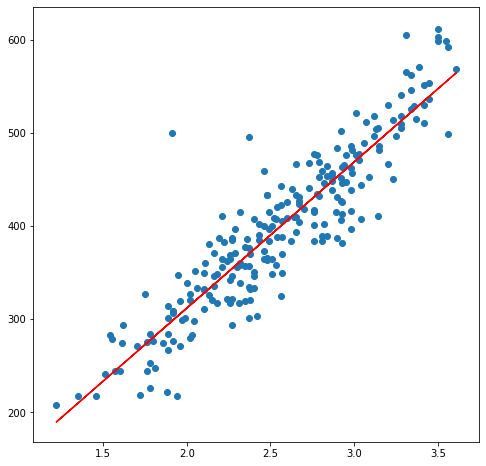

Coefficient: 
 156.8
R-squared: 0.84


In [6]:
lin_reg_plot(raw_spiro['FEV1(l)'],raw_spiro['PEF(l/min)'])
#there's a clear connection between FEV and PEV

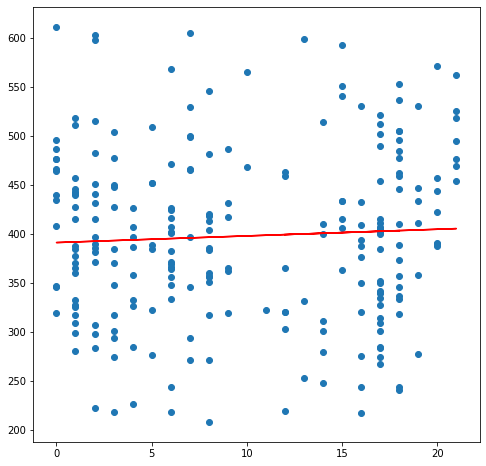

Coefficient: 
 0.68
R-squared: 0.00


In [7]:
#test hypothesis that breathing gets worse during sleep - sleep is from 22 - 6 - adding buffer
sleepTest = raw_spiro.copy() 
sleepTest = sleepTest.drop(['unixDate'],axis=1)
sleepTest.reset_index(drop=True)
#same data - just starting around sleeptime and setting that to zero
sleepTest.loc[sleepTest['Hour'] <= 22,'Hour'] = sleepTest['Hour']+2
sleepTest.loc[sleepTest['Hour'] >= 22,'Hour'] = sleepTest['Hour']-22
wakeTest = sleepTest.copy()
baseTest = sleepTest.copy()
lin_reg_plot(baseTest['Hour'],baseTest['PEF(l/min)'])

#small increase as day goes on

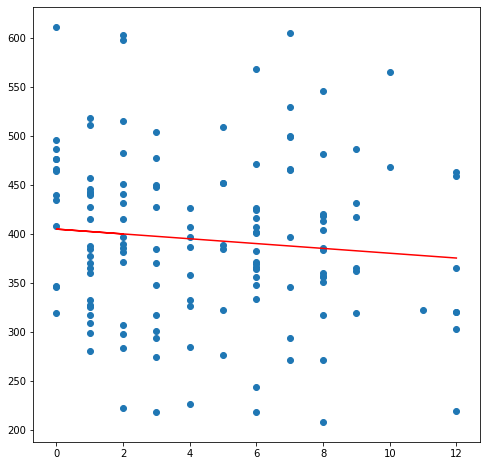

Coefficient: 
 -2.46
R-squared: 0.01


In [8]:
sleepTest = sleepTest.where(sleepTest['Hour']<=12).dropna()
lin_reg_plot(sleepTest['Hour'],sleepTest['PEF(l/min)'])
#decrease during sleep

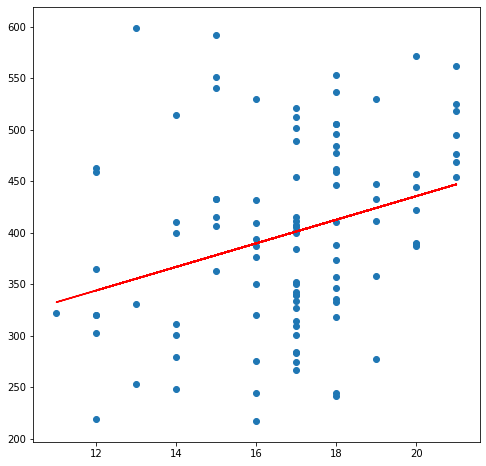

Coefficient: 
 11.44
R-squared: 0.09


In [9]:
wakeTest = wakeTest.where(wakeTest['Hour']>10).dropna()
lin_reg_plot(wakeTest['Hour'],wakeTest['PEF(l/min)'])
#strong increase from wake until near end of day

In [10]:
#let's examine a time series analysis
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=3,center=False).mean()
    rolstd = timeseries.rolling(window=3,center=False).std()
    #Plot rolling statistics:
    plt.figure(figsize=(8, 8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(dfoutput)

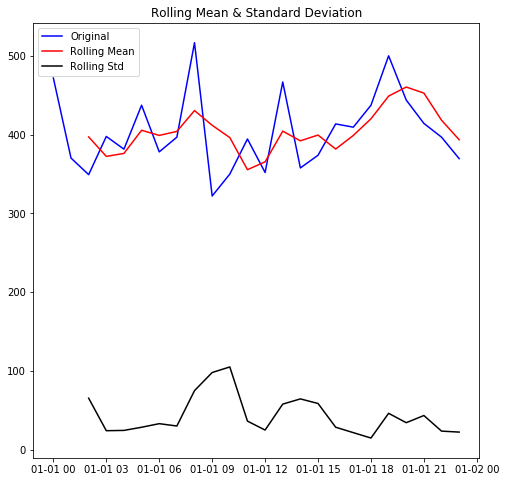

Results of Dickey-Fuller Test:
Test Statistic                 -5.008690
p-value                         0.000021
#Lags Used                      0.000000
Number of Observations Used    23.000000
dtype: float64


In [11]:
#just compare PEF to time
X = raw_spiro.copy()
X = X.set_index('Time')
X = X['PEF(l/min)']
X = X.resample('H').mean()
X = X.interpolate()
test_stationarity(X)

In [12]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [13]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                mse = evaluate_arima_model(dataset, order)
                if mse < best_score:
                    best_score, best_cfg = mse, order
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 1)
solution = evaluate_models(X, p_values, d_values, q_values)

Best ARIMA(0, 1, 0) MSE=1422.000


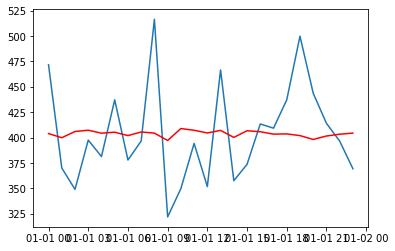

In [14]:
#our time series approximation
model = ARIMA((X),order=(1,0,0),freq='H')
results_AR= model.fit()
plt.plot(X)
plt.plot(results_AR.fittedvalues,color='red')

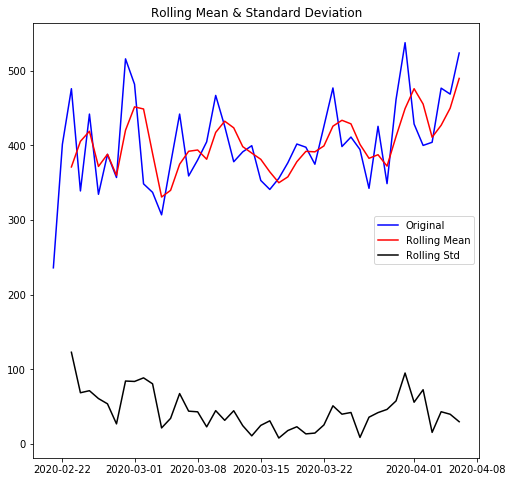

Results of Dickey-Fuller Test:
Test Statistic                 -5.556892
p-value                         0.000002
#Lags Used                      0.000000
Number of Observations Used    45.000000
dtype: float64


In [15]:
#here we are creating a time series by the day
X2 = raw_spiro.copy()
X2 = X2.groupby('Date').mean()
X2.index
X2.set_index(pd.date_range(start=X2.index.min(), end=X2.index.max()), inplace=True)
X2 = X2['PEF(l/min)']

test_stationarity(X2)

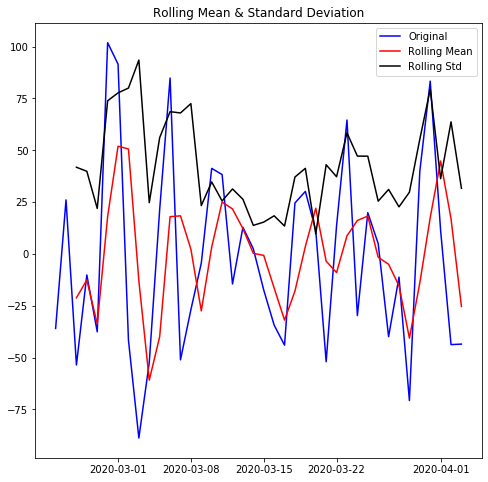

Results of Dickey-Fuller Test:
Test Statistic                -6.564338e+00
p-value                        8.230672e-09
#Lags Used                     1.000000e+01
Number of Observations Used    2.900000e+01
dtype: float64


In [16]:
#more seasonal analysis once I have more data
decomposition = seasonal_decompose(X2)
trend = decomposition.trend
seasonal = decomposition.seasonal

residual = decomposition.resid
test_stationarity(residual.dropna())

Best ARIMA(2, 1, 0) MSE=3698.317


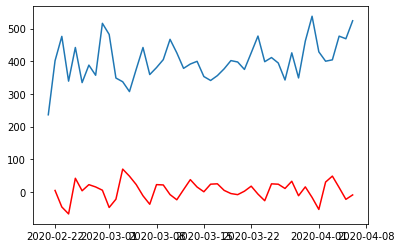

In [17]:
solution = evaluate_models(X2, p_values, d_values, q_values)
model = ARIMA((X2),order=solution,freq='D')
results_AR= model.fit()
plt.plot(X2)
plt.plot(results_AR.fittedvalues,color='red')